In [1]:
import sys
sys.path.insert(0, '../params')
import healpy as hp
import numpy as np
import pylab as pl
from plancklens import utils
import generate_LSS as glss

#sys.path.append('/sharefs/alicpt/users/chenwz/download/cmblensplus2/utils')
#sys.path.append('/sharefs/alicpt/users/chenwz/Testarea/FORECAST/Foreground/foreground_run')

#from utils_mine import *
import generate_LSS as glss

In [2]:
def view_map(m, title, min=None, max=None, cmap='YlGnBu_r'):
     """ View map.
     """
     # TODO beautify this plot
     rot = [180, 60, 0]


     m = hp.read_map(m, verbose=False) if isinstance(m, str) else m
     m[ m==0. ] = np.nan # in case the input map is an apodization mask

     if min==None: min = m[ ~np.isnan(m) ].min()
     if max==None: max = m[ ~np.isnan(m) ].max()
     
     hp.orthview(m, title=title, min=min, max=max, rot=rot, half_sky=True, cmap=cmap)
     hp.graticule()

import utils
def k2d_map(map):
    alm = hp.map2alm(map)
    dlm = hp.almxfl(alm, cut * cli(q2k(np.arange(lmax + 1)))
                                     * q2d(np.arange(lmax + 1)))
                                     
    return hp.alm2map(dlm,nside)

def k2q_map(map):
    alm = hp.map2alm(map)
    dlm = hp.almxfl(alm, cut * cli(q2k(np.arange(lmax + 1))))                                  
                                   
    return hp.alm2map(dlm,nside)


def q2k_map(map):
    alm = hp.map2alm(map)
    klm = hp.almxfl(alm, cut * q2k(np.arange(lmax + 1)))                              
    return hp.alm2map(klm,nside)

def q2d_map(qmap):
    q2d = lambda l: (l*(l + 1)) ** 0.5 # potential -> deflection
    qlm = hp.map2alm(qmap)
    dmap = hp.alm2map(hp.almxfl(qlm, cut * q2d(np.arange(lmax + 1))),nside)
    return dmap

In [3]:
nside = 2048
lmax = 3*nside-1   # important to set lmax to 3*nside-1 for lensing related calculation

file_indices = 0

In [ ]:
q2k = lambda l: l*(l + 1) / 2 # potential -> convergence
q2d = lambda l: (l*(l + 1)) ** 0.5 # potential -> deflection
cut = np.where((np.arange(lmax + 1) > 20) * (np.arange(lmax + 1) < lmax), 1, 0) # band limit


#tracers_filename = f"/sharefs/alicpt/users/chenwz/Testarea/FORECAST/A_NEW_WORK_MUST/rec/LSS_tracer/Kappa_CIB_MUST/tracers_KIL_{file_indices}.npy"    # set save path for single tracer maps
#comb_filename = f"/sharefs/alicpt/users/chenwz/Testarea/FORECAST/A_NEW_WORK_MUST/rec/LSS_tracer/COMB_KIL/comb_KIL_{file_indices}.npy"                # set save path for combined tracer map


rec_qlm_filename = f"qlm_QE_MV_{file_indices:04d}.fits"    # set path for reconstructed lensing potential alm
P_filename = f"potential_{file_indices:05d}.fits"                             # set path for input true lensing potential map


pmap = hp.read_map(P_filename)
kmap = q2k_map(pmap)
plm_input = hp.map2alm(pmap, lmax=lmax)

plm_rec = hp.read_alm(rec_qlm_filename)
pmap_rec = hp.alm2map(plm_rec, nside)
kmap_rec = q2k_map(pmap_rec)


# Calculate reconstruction noise power
nlpp = np.loadtxt('wiener_red.dat')[1]
nlpp = np.pad(nlpp, (0, lmax+1-len(nlpp)), mode='constant')    # important to pad zeros to nlpp to lmax length

# Prepare tracers power matrix
cls = np.load('k_I_MUST_power_matrix.npy')


surveys = ['kappa','CIB','BGS','LRG','ELG1','ELG2','udrop','gdrop','rdrop']

In [ ]:
mask = hp.read_map(f'/home/chen/Testarea/A_NEW_WORK_MAIN_revise/mask/AliCPT_20uKcut150_C_2048.fits')

#######################  Generate LSS tracer simulation  ##########################

In [ ]:
tracer_maps = glss.ones(nside,lmax,pmap,nlpp[:lmax+1],cls[:,:,:lmax+1],wantmap=1)
tracer_alms = [hp.map2alm(tracer,lmax) for tracer in tracer_maps]

tracer_maps[0] = kmap_rec               # set reconstructed kappa map as first tracer (CMB internal reconstruction)

/home/chen/anaconda3/envs/lens/lib/python3.10/site-packages/healpy/sphtfunc.py:563: ComplexWarning: Casting complex values to real discards the imaginary part
  cls_list = [np.asarray(cls, dtype=np.float64)]


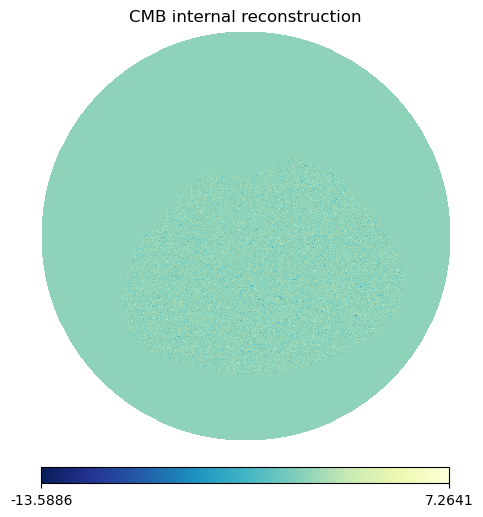

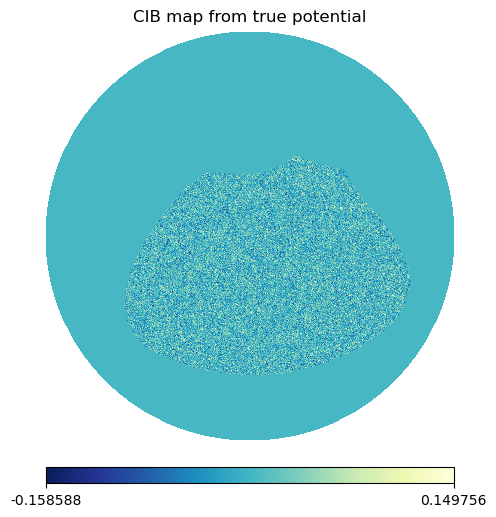

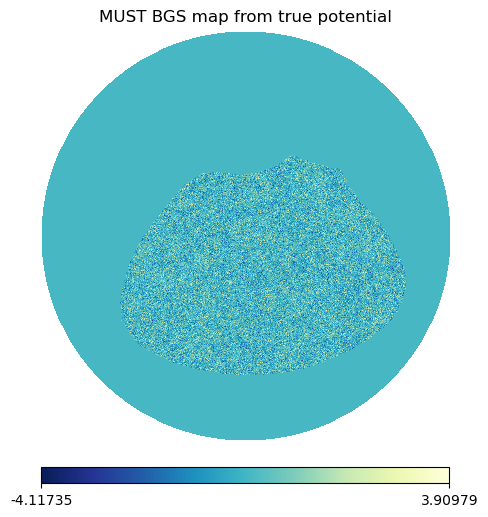

In [ ]:
hp.orthview(tracer_maps[0]*mask, half_sky=1, rot=[180,60], title='CMB internal reconstruction', cmap='YlGnBu_r')
hp.orthview(tracer_maps[1]*mask, half_sky=1, rot=[180,60], title='CIB map from true potential', cmap='YlGnBu_r')
hp.orthview(tracer_maps[2]*mask, half_sky=1, rot=[180,60], title='MUST BGS map from true potential', cmap='YlGnBu_r')

#######################  Combine LSS tracer simulation   ##########################   (CMB + CIB + MUST)

##### prepare the whole single tracers to be combined

In [ ]:
tracers = {surveys[i]:tracer_maps[i]*mask for i in range(len(surveys))}
klm = hp.map2alm(kmap*mask,lmax)
tracers_alm = [hp.map2alm(tracer,lmax) for tracer in tracers.values()]

#### calculate some scale factors and auxiliary cl.

In [ ]:
from generate_LSS import *

aux_cl, A = calculate_sim_weights(cls[:,:,:lmax+1])

#### let's do the combination

In [ ]:
import importlib
import LSS_tracer_comb
importlib.reload(LSS_tracer_comb)

loading modules...
loading modules...


<module 'LSS_tracer_comb' from '/home/chen/Testarea/A_NEW_WORK_MAIN_revise/LSS_tracer_simulation/LSS_tracer_comb.py'>

In [ ]:
from LSS_tracer_comb import *
C_II = cal_tracer_cov(nside,lmax,tracers,mask)
C_KI = cal_kappa_tracer_cross(nside,lmax,kmap,tracers,mask)

##### noisy

In [ ]:
comb = combine_maps(tracers, C_II, C_KI, lmax, nside, gal_cut=100)

##### signal only

In [ ]:
signals = tracers.copy()
for i,key in enumerate(signals):
    signals[key] = hp.alm2map(hp.almxfl(klm, A[i,0,:]),nside)

In [ ]:
comb_signal = combine_maps(signals, C_II, C_KI, lmax, nside, gal_cut=100)

In [ ]:
def cal_rho(nside,lmax):
    """
    
    ###########  Calculate the correlation coefficient between the combined tracer and the true lensing convergence  ############

    """

    ls = np.arange(lmax+1)
    q2k = lambda l: l*(l + 1) / 2

    kmap = q2k_map(hp.read_map(f"{P_filename}",field=(0),))

    comb_map = comb
    clkk = hp.anafast(kmap)

    rhos = []
    for i,map in enumerate(tracer_maps):
        rhos.append(hp.anafast(kmap*mask,map*mask)[:lmax+1]/fsky/np.sqrt(clkk[:lmax+1] * hp.anafast(map*mask)[:lmax+1]/fsky))

    rho_comb = []
    for i,map in enumerate(comb_map):
        rho_comb.append(hp.anafast(kmap*mask,map*mask)[:lmax+1]/fsky/np.sqrt(clkk[:lmax+1] * hp.anafast(map*mask)[:lmax+1]/fsky))


    rhos_binned = np.zeros((len(tracer_maps), 50))
    for i in range(len(tracer_maps)):
        _,rhos_binned[i] = get_binned(nside,60,rhos[i][10:3030],lmax=3019)

    rho_comb_binned = np.zeros((len(comb_map), 50))
    for i in range(len(comb_map)):
        lbin,rho_comb_binned[i] = get_binned(nside,60,rho_comb[i][10:3030],lmax=3019)

    return rhos_binned, rho_comb_binned, lbin